In [52]:
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)


In [3]:
act = pd.read_csv('data/atusact_2014.dat')
cps = pd.read_csv('data/atuscps_2014.dat')
resp = pd.read_csv('data/atusresp_2014.dat')
rost = pd.read_csv('data/atusrost_2014.dat')
rostec = pd.read_csv('data/atusrostec_2014.dat')
sum_ = pd.read_csv('data/atussum_2014.dat') \
                  .rename(columns={'tucaseid':'TUCASEID'})
who = pd.read_csv('data/atuswho_2014.dat')
ind_codes = pd.read_csv('ind_codes.csv', sep="|")
acts = pd.read_excel('data/lexiconwex2014.xls', 1, header=1, parse_cols=1) \
                    .rename(columns={'6-digit activity code' : 'code',
                                     'Activity' : 'activity'}).dropna()

## What percent of part-time employees are also students? 
## What percent of students are also employed?
 - resp 
     - TESCHENR - are you enrolled in high school, college, or university? 
         - (1 - Yes, 2 - No)
     - TELFS - Edited: labor force status
         - (1 - Employed - at work, 2 - Employed - absent, 3 - Unemployed - on layoff, 4 - Unemployed - looking, 5 - Not in labor force)
     - TEHRFTPT - do you usually work more than 35 hours per week at your Respondent File job(s)/family business? 
         - (1 - Yes, 2 - No, 3 - Hours Vary)
     - TESPEMPNOT - Edited: employment status of spouse or unmarried partner
         - (1 - Employed, 2 - Unemployed)
     - TRDPFTPT - Full time or part time employment status of respondent
         - (1 - Full time, 2 - Part time)
     - TRSPFTPT - Full time or part time employment status of spouse or unmarried partner
         - (1 - Full time, 2 - Part time)
     - TESCHFT - Edited: are you enrolled as a full-time or part-time student?
         - (1 - Full time, 2 - Part time)

In [4]:
studies_v_work = resp[['TUCASEID', 'TESCHENR', 'TESCHFT', 'TELFS', 'TEHRFTPT', 
                       'TESPEMPNOT', 'TRDPFTPT', 'TRSPFTPT']] \
      .rename(columns={'TESCHENR' : 'enrolled', 'TELFS' : 'status', 
                       'TEHRFTPT' : 'hours', 'TESPEMPNOT' : 'spouse_emp', 
                       'TRDPFTPT' : 'full', 'TRSPFTPT' : 'spouse-full',
                       'TESCHFT' : 'full-student'})

students = studies_v_work[studies_v_work['enrolled'] == 1]
students['status'].value_counts()/len(students)

1    0.463783
5    0.398390
4    0.096579
2    0.034205
3    0.007042
dtype: float64

#### Employed students

From this data, if we sum the percentages for values 1 (Employed - at work) and 2 (Employed - absent), we see that approximately **49.8%** of students are also employed.  From here, let's see what percent of these employed students are working full-time jobs.

In [5]:
students['full'][students['status'] < 2].value_counts()/len(students[students['status'] < 2])

1    0.533623
2    0.466377
dtype: float64

#### Students employed full-time

Here we see that **53.4%** of employed students work full-time jobs, with part-time jobs bringing up the other 46.6%.  Out of curiousity, let's go back and see what percentage of unemployed students have employed spouses.

In [6]:
students['spouse_emp'][students['status'] > 1].value_counts()/len(students[students['status'] > 1])

-1    0.853659
 1    0.125704
 2    0.020638
dtype: float64

#### Employed spouses of students
Finally, we see that **12.6%** of our unemployed students have employed spouses

## Is there a relationship between weekly wage and care for older/younger relatives?
 - time spent?
 - in home or otherwise for older?
 - time spent working vs. time spent 
 
 - resp
     - TRERNWA - Weekly earnings at main job (2 implied decimals)
         - 0 - 288461 (in cents)
     - TRTEC - Total time spent providing eldercare (in minutes)
         - 0 - 1440 (in minutes)
     - TRTEC_LN - Time spent providing eldercare by activity (in minutes)
         - 0 - 1440 (in minutes)
         - Note: Excludes time spent in activities with codes = 01xxxx or 0805xx
     - TEHRUSLT - Edited: total hours usually worked per week (sum of TEHRUSL1 and Respondent File, TEHRUSL2)
         - 0 - 999 (in hours)
         - -4 (Hours vary)
     - TULINENO - ATUS person line number
         - 0 - 30
 - rostec
     - TRELHH - Eldercare recipient is a household member
         - (0 - Recipient is not a household member, 1 - Recipient is a household member)
     - TULINENO - ATUS person line number
         - 0 - 30

In [42]:
elder_care = resp[['TUCASEID', 'TRERNWA', 'TRTEC', 'TEHRUSLT']] \
                .rename(columns={'TUCASEID': 'case_id', 'TRERNWA' : 'wages',
                                 'TRTEC': 'care_time', 'TEHRUSLT' : 'work_time'})

elder_care = elder_care[elder_care.care_time > 0]
elder_care = elder_care[elder_care.wages > 0]
elder_care.corr()
#sort('TRERNWA', ascending=False, inplace=False)

,case_id,wages,care_time,work_time
case_id,1.000000,-0.035301,0.032763,-0.016667
wages,-0.035301,1.000000,0.048380,0.349187
care_time,0.032763,0.048380,1.000000,0.141882
work_time,-0.016667,0.349187,0.141882,1.000000


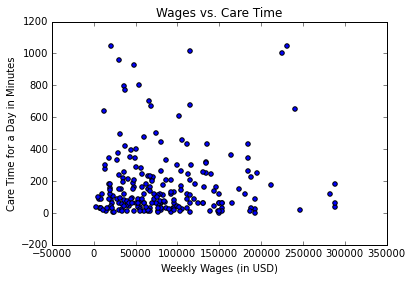

In [56]:
elder_care.plot('wages', 'care_time', kind='scatter', title="Wages vs. Care Time")
plt.xlabel('Weekly Wages (in USD)')
plt.ylabel('Care Time for a Day in Minutes')
plt.show()

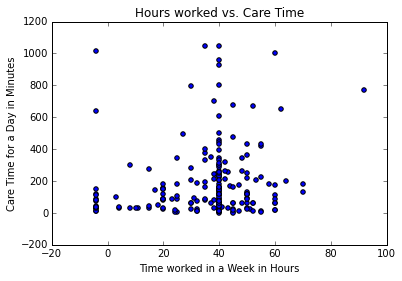

In [57]:
elder_care.plot('work_time', 'care_time', kind='scatter', title="Hours worked vs. Care Time")
plt.xlabel('Time worked in a Week in Hours')
plt.ylabel('Care Time for a Day in Minutes')
plt.show()

#### Wages and work hours compared to time spent caring for the elderly
Based on the data we have here, there is **no strong connection** between time spent caring for the elderly and wages earned or hours worked.  From our Pearson correlations, we get almost as strong a correlation of care time to case ID as we do care time to wages.  The strongest correlation (aside from work time to wages) is a slight one between care time and work time at a positive .1419.

## Industry worked vs. anything?

## Various activities across prescence of spouse, partner, neither
- resp
    - TRSPPRES - Presence of the respondent's spouse or unmarried partner in the Respondent File, household
        - (1 - Spouse present, 2 - Unmarried partner present, 3 - No spouse or unmarried partner present)
    - 

In [8]:
merged = pd.merge(pd.merge(pd.merge(act, cps), pd.merge(resp, rost))
         , pd.merge(pd.merge(rostec, sum_), who))

## Time spent with work acquaintances outside of work for various industries
- resp
    - TRTCCC - Total nonwork-related time respondent spent with customers, clients, and Respondent File coworkers (in minutes)
         - 
    - TEHRUSLT - Edited: total hours usually worked per week (sum of TEHRUSL1 and Respondent File, TEHRUSL2)
         - 0 - 999 (in minutes)
